<a href="https://colab.research.google.com/github/deltorobarba/science/blob/main/schroedinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Simulating Quantum Time Evolution with Time-Dependent Schrödinger**

In [ ]:
!pip install cirq openfermion -q
import cirq
import numpy as np
import matplotlib.pyplot as plt

<font color="blue">**Description of Quantum Systems: Classical vs Quantum Methods**

Quantum systems in chemistry and physics can be described and computed with either classical and quantum methods:

* **Model**: Classical (Newton Mechanics) vs Quantum (Schrödinger equation)
* **Type**: Static (State) vs Dynamical (Evolution)
* **Computing**: Classical Computing vs Quantum Computing

<font color="blue">*1. Classical (Newtonian) Mechanics (**Static and Dynamic**): $F = m \cdot a$*
* Ignores electrons and consider atoms as spheres connected by springs (force fields)
* **Classical - Dynamic**: Molecular dynamics (MD). How proteins enfold and move? GROMACS, NAMD, AMBER.
* **Classical - Static**: Molecular Docking / Energy Minimization. Geometrically: Does medication fit to enzyme? AutoDock, Rosetta.
* **Quantum computing methods:** Future: Navier Stokes (fluid dynamics) with HHL to solve linear systems and differential equations exponentially faster than classical computers. For weather and climate: simulate weather with a much finer grid (e.g. 100m)

<font color="blue">*2. Quantum Mechanics (**Static**): Time-independent Schrödinger Equation $\hat{H}|\psi\rangle = E|\psi\rangle$*
* Includes electrons. **Approximates Ground State via optimization** with variation $\delta \langle H \rangle = 0$ to find global optimum in energy landscape. Stationary state important for calculating binding energies: If $\psi$ is an eigenstate of $\hat{H}$, then time evolution is trivial: $\Psi(t) = \psi e^{-iEt/\hbar}$. Probability density $|\Psi(t)|^2$ remains constant over time = states are stationary.
* **Classical computing:** Hartree-Fock (mean field of $\psi$), DFT (electron density $\rho$), Post-HF (calculate correlation energies)
* **Quantum computing** (**NISQ**): Variational Quantum Eigensolver. Quantum Advantage: finds correlation energy with entanglement.

<font color="blue">*3. Quantum Mechanics (**Dynamic**): Time-dependent Schrödinger Equation $i\hbar \frac{\partial}{\partial t} \Psi(\mathbf{r}, t) = \hat{H} \Psi(\mathbf{r}, t)$*
* **Simulate Time Evolution** $e^{-i\hat{H}t}$ of Quantum State $|\Psi(t)\rangle = e^{-i\hat{H}t/\hbar} |\Psi(0)\rangle$ via Unitary Transformation. For Quantum Chaos, OTOC, Scrambling (Black Holes) reaction dynamics (observe how bonds break and reform during a collision). No forward theorem!
* **Classical computing**: Time-Dependent DFT (TD-DFT) used to classically calculate excitations (fluorescence, spectra). However only for short times and small systems. To solve the time-dependent equation $i\hbar \frac{\partial}{\partial t} \Psi = \hat{H} \Psi$ classically at scale, you have to apply operator $e^{-i\hat{H}t/\hbar}$ to wavefunction. In system with $N$ particles, complexity grows exponentially with $N$.
* **Quantum computing** (**Fault-Tolerant**): LCU, Trotterization, Qubitization (with Quantum Walks and Block Encoding)

<font color="blue">*Appendix: Wy we can solve the Schrödinger equation analytically only for very small systems*

* **Analytical** solution for Schrödinger in Hydrogen atom. But a second electron add electron-electron repulsion = three-body problem.
* **Approximate** Schrödinger with DFT and HF on classical computers via **optimization (variation)** for larger systems than Hydrogen
* **Simulate** time evolution for even larger systems = Quantum computer doesn't store information anymore - **it is the Hilbert space!**


<font color="blue">**Quantum Dynamics: Phenomena, Mechanism, Metric and Limits**

<font color="blue">*1. Phenomenon: Quantum Chaos*

* **Quantum Chaos** how deterministic quantum systems emulate behavior of classical chaotic systems despite linearity of Schrödinger. Unlike classical chaos (sensitivity to initial conditions), Quantum Chaos is defined by the statistics of the energy eigenvalues (Energy Level Statistics).
* **Spectral Statistics:** Since trajectories do not exist, chaos is identified by distribution of energy eigenvalues. Chaotic systems exhibit **Level Repulsion** (Wigner-Dyson statistics), whereas non-chaotic (integrable) systems show **Level Clustering** (Poisson statistics). In a chaotic system, energy levels repel each other (Wigner-Dyson distribution). They don't like to bunch up. In a non-chaotic (integrable) system, energy levels are random (Poisson distribution) and often cross. Chaotic Hamiltonians are the "engines" that drive thermalization and scrambling.
* **Quantum Suppression of Chaos:** Interference effects often "smear" classical chaotic behavior, making quantum systems more stable over long periods than their classical counterparts.
* **Quantum Scars:** A phenomenon where the probability density of certain high-energy eigenstates (wavefunctions) remains concentrated around the paths of unstable classical periodic orbits, effectively "scarring" the quantum state with classical memory.

<font color="blue">*2. Mechanism: Quantum Scrambling*

* Scrambling is dynamic process by which local information is redistributed into global, many-body entanglement.
* Quantum Scrambling: delocalization of quantum information. Information initially stored in a single qubit (local) spreads via entanglement to cover the entire system (global).
  * Local vs. Global: A "simple" operator (like a Pauli $X$ on qubit 1) evolves into a "complex" operator (a long string of $X, Y, Z$ on many qubits).
  * "Hidden" Information: Once scrambled, the information is inaccessible to local measurements. You would need to measure half the system's particles simultaneously to recover the original bit.
  * Use Case: This is why Black Holes are considered the "fastest scramblers in nature."
* **Operator Spreading:**  A local operator $\hat{V}$ (e.g., a Pauli gate on one qubit) evolves under a chaotic Hamiltonian into a highly non-local operator $\hat{V}(t) = e^{iHt}\hat{V}e^{-iHt}$ that consists of long chains of Pauli strings across the entire Hilbert space.
* **Thermalization & ETH:** Scrambling is the microscopic engine behind the **Eigenstate Thermalization Hypothesis (ETH)**. It explains how a pure quantum state can locally appear thermal; the "missing" information is not lost but hidden in complex many-body correlations.
* **Significance:** Information becomes "scrambled" when it cannot be recovered by any local measurement, requiring a measurement of a significant fraction of the total system to reconstruct.

<font color="blue">*3. Metric: Out-of-Time-Ordered Correlators (OTOC)*

* OTOC is mathematical "thermometer" used to quantify rate of scrambling and quantum Lyapunov exponent:
  * How do we prove information is scrambled and not just gone? We try to reverse time! An OTOC measures how sensitive reversal is to a tiny error (like a "Butterfly Effect").
  * "If I poke the system now, how much does it affect a measurement I made in the past (if I evolved backward)?"
* Formula: $C(t) = \langle [\hat{W}(t), \hat{V}(0)]^\dagger [\hat{W}(t), \hat{V}(0)] \rangle$
  * $\hat{V}(0)$: The "Butterfly" (a small local perturbation at start).
  * $\hat{W}(t)$: The measurement later in time.
  * At $t=0$, $W$ and $V$ commute (they are on different qubits). The commutator is 0.
  * As time evolves, $\hat{W}(t)$ grows spatially (scrambling).
  * Eventually, $\hat{W}(t)$ hits the qubit where $\hat{V}$ sits. They no longer commute.
  * The commutator grows, and $C(t)$ deviates from zero.
  * Result: rate at which the OTOC grows is Lyapunov Exponent ($\lambda$), the "speed limit" of chaos.
* **Four-Point Function:** Unlike standard correlators, the OTOC requires evolving forward and backward in time: $W(t) = e^{iHt} W(0) e^{-iHt}$.
* **The Growth Phase:** In the early stages of a chaotic system, the OTOC grows exponentially: $C(t) \sim \hbar^2 e^{2\lambda t}$.
* **Quantum Lyapunov Exponent** ($\lambda$): This $\lambda$ is the direct quantum analogue of the classical Lyapunov exponent. It represents the speed at which the "butterfly effect" (the perturbation $\hat{V}$) propagates through the system's degrees of freedom.

<font color="blue">*4. Extremes and Limits: Black Holes & Maldacena Bound*

* Study of scrambling reaches its physical limit in the context of General Relativity and String Theory.
* **The Fastest Scramblers:** Theoretical evidence (via the AdS/CFT correspondence) suggests that Black Holes are the most efficient scramblers of information allowed by the laws of physics.
* **The Maldacena-Shenker-Stanford (MSS) Bound:** There is a fundamental upper limit on the rate of chaos (the Lyapunov exponent) in any thermal quantum system: $\lambda \leq \frac{2\pi k_B T}{\hbar}$
* **Black Hole Saturation:** Black holes are unique because they saturate this bound, exhibiting the maximum possible "speed of chaos" at their Hawking temperature.

<font color="blue">*5. ETH (Eigenstate Thermalization Hypothesis) and Quantum Error Correction*
* ETH (Eigenstate Thermalization Hypothesis): You asked yourself: How does this relate to thermodynamics? ETH explains how an isolated quantum system (pure state) can act like a thermal bath (mixed state). Connection: Scrambling mixes the information so thoroughly that any local part of the system looks like a random thermal mixture, even though the global state is pure.
* Quantum Error Correction (The "Good" Side of Scrambling): Scrambling sounds bad (loss of info), but for Quantum Computers, it's good! If you encode a logical qubit into a scrambled state (like a Toric Code or Surface Code), a local error (hitting just one physical qubit) cannot destroy the information, because the info is delocalized everywhere. Insight: We use scrambling intentionally to protect data.

<font color="blue">*6. Appendix: If System is not scrambling*
* Check on the OTOC formula $C(t) = \langle [\hat{W}(t), \hat{V}(0)]^\dagger [\hat{W}(t), \hat{V}(0)] \rangle$.
* If the system is not scrambling (e.g., a simple rotation of independent qubits), and operator $\hat{W}$ acts on Qubit 1 while $\hat{V}$ acts on Qubit 5. Even after time $t$, will the commutator $[\hat{W}(t), \hat{V}(0)]$ ever be non-zero?
* In a non-scrambling system where qubits evolve independently, commutator $[\hat{W}(t), \hat{V}(0)]$ will remain zero for all time. Since there is no interaction term in the Hamiltonian to link Qubit 1 and Qubit 5, the time-evolved operator $\hat{W}(t)$ will only consist of terms acting on Qubit 1. Because operators acting on different qubits always commute, the "butterfly" never feels the "poking," and OTOC never grows.


<font color="blue">**Methods for Simulating Quantum Time Evolution**</font>

The central challenge in quantum dynamics is implementing the unitary propagator $U(t) = e^{-i\hat{H}t}$ on quantum hardware that only supports a discrete set of elementary gates. We distinguish between three primary approaches:

<font color="blue">*1. Trotter-Suzuki Decomposition (Product Formulas)*</font>

This is the most intuitive approach, based on approximating the propagator by decomposing the Hamiltonian into commuting fragments.

* Since $[\hat{T}, \hat{V}] \neq 0$, it follows that $e^{-i(\hat{T}+\hat{V})t} \neq e^{-i\hat{T}t}e^{-i\hat{V}t}$.  The first-order Trotter-Suzuki formula utilizes the limit: $e^{-i\hat{H}t} = \lim_{n \to \infty} \left( \prod_j e^{-i\hat{h}_j t/n} \right)^n$
* **Problem:** Real nature is continuous. A molecule evolves under all its forces (Kinetic + Potential) simultaneously. **Bottleneck:** A Quantum Computer is digital. It can only do one thing at a time: "Rotate this qubit" **OR** "Entangle these two". It cannot do both at the exact same instant. **Solution (Trotterization):** We slice time into tiny chunks $\Delta t$. In each chunk, we quickly toggle between the forces. $e^{-i(H_{int} + H_{field})t} \approx \left( e^{-i H_{int} \Delta t} \cdot e^{-i H_{field} \Delta t} \right)^n$. If the switching is fast enough ( is large), the qubit "feels" like both forces are acting at once.
* Example: Ising Model Simulation ($H = Z_0 Z_1 + X_0 + X_1$). Interaction ($Z_0 Z_1$): Tries to align/anti-align spins (Entanglement). Transverse Field ($X$): Tries to flip spins (Dynamics).
* **Physics Mechanism:** The Hamiltonian $\hat{H} = \sum \hat{h}_j$ is divided into small time steps $\Delta t = t/n$. In each step, every term is applied individually. Since quantum gates represent natural rotations of the form $e^{-i \theta P}$ (where $P$ is a Pauli operator), these partial propagators can be directly translated into gates.
* **Error Analysis:** The error scales quadratically with the step size ($O(\Delta t^2)$ for 1st order). For high-precision long-time studies (e.g., Quantum Chaos), Trotter requires an extremely high number of gates, which often leads to terminal decoherence on current NISQ hardware.

<font color="blue">*2. Linear Combination of Unitaries (LCU)*</font>

LCU provides the theoretical foundation for advanced fault-tolerant algorithms. Rather than "chopping" the exponential function, it represents it directly as a sum of unitaries.

* Express a (not necessarily unitary) operator $A$ as a weighted sum of simple unitaries $U_l$: $A = \sum_{l=0}^{L-1} \alpha_l U_l, \quad \alpha_l > 0$
* **Application to Time Evolution:** The propagator $e^{-iHt}$ is decomposed into an LCU form using its Taylor series expansion.
* **Implementation:** This requires two primary oracles:
  1. **PREPARE:** Prepares an auxiliary state (ancilla) that encodes the coefficients $\sqrt{\alpha_l}$.
  2. **SELECT:** Applies the unitary $U_l$ to the system register, conditioned on the state of the ancilla register.


* **Trade-offs:** LCU offers drastically better error scaling than Trotter but requires additional ancilla qubits and complex controlled operations.

<font color="blue">*3. Qubitization (Quantum Walks & Block Encoding)*</font>

Qubitization is currently the "gold standard" for resource-efficient simulations on fault-tolerant quantum computers.

* Hamiltonian $\hat{H}$ is embedded (**block-encoded**) into a larger unitary matrix $U_H$ such that $\hat{H}$ appears in upper-left block: $U_H = \begin{pmatrix} \hat{H}/\lambda & \dots \\ \dots & \dots \end{pmatrix}$
* **Theory (Quantum Walk):** Instead of calculating $e^{-iHt}$ directly, one constructs a **Walk Operator** $Q$ through a combination of reflection operators and the block encoding of $\hat{H}$.
* **Energy Mapping:** The eigenvalues of $Q$ are linked to the eigenvalues $E$ of the Hamiltonian via the relation $\mu = e^{\pm i \arccos(E/\lambda)}$.
* **Precision:** he complexity scales linearly with time $t$ and only logarithmically with the desired precision $1/\epsilon$. This represents an exponential improvement over Trotter regarding accuracy.
* **Use of Dirac Operators:** The Dirac operator $\mathcal{D}$ (or spin chains) is often used as a benchmark because its algebraic structure (sum of Paulis) allows for highly efficient block encoding.


*When simulating Quantum Chaos, spectral resolution is paramount. While Trotter "blurs" the eigenvalues due to approximation errors, Qubitization preserves the spectral structure almost perfectly. Remember: In Qubitization, the quantum computer doesn't just mimic the dynamics—it becomes mathematically identical to the problem's Hilbert space.*

| Method | Strategy | Scaling (Precision) | Hardware Requirements |
| --- | --- | --- | --- |
| **Trotter** | Product Approximation | Polynomial ($1/\epsilon^p$) | Low (NISQ-friendly) |
| **LCU** | Taylor Series Sum | Logarithmic ($\log(1/\epsilon)$) | Medium (Ancillas required) |
| **Qubitization** | Unitary Embedding | Logarithmic ($\log(1/\epsilon)$) | High (Fault-tolerance needed) |



<font color="blue">**Trotterization: Ising Model Example ($H = Z_0 Z_1 + X_0 + X_1$)**

* **Time steps (dt):** We divide the total simulation time $t$ by the number of steps $n$. The smaller $dt$, the lower the error resulting from the non-commutation of $X$ and $Z$.
* **$ZZ$-Interaction:** An $e^{-i Z \otimes Z \theta}$ operator is not natively available on most quantum computers. It is constructed ("synthesized") using the sequence: CNOT $\rightarrow$ RZ $\rightarrow$ CNOT.
* **$X$-Rotation:** The term $e^{-i X \theta}$ corresponds exactly to an RX gate.
* **Loop:** We repeat this sequence 'steps' times (trotter_steps = 3).
* (Possible further tasks: Calculate the Trotter error. Implement second-order Suzuki-Trotter).

<font color="blue">*Appendix:*
* Instead of building CNOT-RZ-CNOT manually, Cirq offers the `ZZPowGate`. It is more compact, but one must be careful with the conversion.
* A `ZZPowGate` with exponent $e$ performs the operation $\exp(-i \frac{\pi}{2} e Z \otimes Z)$. However, we want $\exp(-i \cdot dt \cdot Z \otimes Z)$.
* Setting them equal: $\frac{\pi}{2} e = dt \quad \Rightarrow \quad e = \frac{2 \cdot dt}{\pi}$

<font color="blue">*The diagram below confirms that the code is working correctly:*

* It entangles the qubits (interaction).
* It rotates them individually (field).
* It repeats this 3 times to approximate the time evolution.

$ZZ$-Interaction (Entanglement): "Sandwich" structure, which simulates the term $e^{-i Z_0 Z_1 t}$

*The first CNOT stores the "parity" of the qubits (are they the same or different?) in Qubit 1. The Rz rotates the phase based on this info. The second CNOT reverses the change of basis. Together, this results in the interaction.*

```
0: ───@────────────────@───
      │                │
1: ───X───Rz(0.212π)───X───

```

$X$-Field (external field): These are Rx gates (rotation around the X-axis). They act on each qubit individually. This simulates the term $e^{-i X t}$ (the magnetic field).

```
0: ───Rx(0.212π)───
1: ───Rx(0.212π)───

```

**The number $0.212 \pi$**

* Time is 1.0.
* Steps are 3 $→$ $dt = 1/3$.
* The formula for rotation is $2 \cdot dt$, so $2/3 \approx 0.666$ radians.
* Cirq often displays angles as multiples of $\pi$. $0.666 \text{ rad} \approx 0.212 \cdot \pi$.
* So the number is exactly correct: It is a rotation of approx. 38 degrees ($0.212 \times 180^\circ$) per step.

In [ ]:
# Simple Trotterization (Trotter-Suzuki) mit Cirq

def generate_trotter_step(qubits, dt):
    """
    Generator für einen einzelnen Trotter-Schritt.
    Yieldet die Operationen für den Hamiltonian H = ZZ + X
    """
    n = len(qubits)

    # 1. Interaktions-Terme (ZZ-Interaktion)
    # e^(-i * Z * Z * dt)
    # Cirq hat hierfür keine nativen "Parameter" wie Qiskit,
    # daher bauen wir es explizit: CNOT -> Rz -> CNOT
    for i in range(n - 1):
        yield cirq.CNOT(qubits[i], qubits[i+1])
        yield cirq.rz(rads=2 * dt).on(qubits[i+1])
        yield cirq.CNOT(qubits[i], qubits[i+1])

    # 2. Feld-Terme (X-Feld)
    # e^(-i * X * dt) -> entspricht Rx(2 * dt)
    for i in range(n):
        yield cirq.rx(rads=2 * dt).on(qubits[i])

def build_trotter_circuit(num_qubits, time, steps):
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()

    dt = time / steps

    # Wir loopen über die Schritte und fügen die Operationen hinzu
    for _ in range(steps):
        circuit.append(generate_trotter_step(qubits, dt))

    return circuit

# --- Parameter ---
num_qubits = 2
simulation_time = 1.0
trotter_steps = 3

# --- Ausführung ---
circuit = build_trotter_circuit(num_qubits, simulation_time, trotter_steps)

print(f"Cirq Trotter-Circuit ({trotter_steps} Schritte):")
print(circuit)

Cirq Trotter-Circuit (3 Schritte):
0: ───@────────────────@───Rx(0.212π)───@────────────────@───Rx(0.212π)───@────────────────@───Rx(0.212π)───
      │                │                │                │                │                │
1: ───X───Rz(0.212π)───X───Rx(0.212π)───X───Rz(0.212π)───X───Rx(0.212π)───X───Rz(0.212π)───X───Rx(0.212π)───


<font color="blue">**Unified Trotter Simulation (Ising Model)**

This code defines a single, general-purpose simulation engine.
* Hamiltonian: Hamiltonian to: $H = J \cdot (Z_0 Z_1) + B \cdot (X_0 + X_1)$
* Case 1 (Time Evolution): We set $J=1, B=1$ and watch how states $|00\rangle$ and $|11\rangle$ evolve.
* Case 2 (Regime Change): We vary $J$ and $B$ to see "Rabi Oscillations" vs. "Interaction Blockade".

**Why this works (The Physics)**

In the Standard Dynamics ($J=1, B=1$), the forces are balanced.
* The field $B$ tries to rotate $|00\rangle \to |01\rangle \to |11\rangle$.
* The interaction $J$ adds a phase penalty.
* Result: You see complex mixing (the waves in Plot 1).

In the Strong Interaction ($J=5, B=1$), the forces are unbalanced.
* The interaction term $J \cdot Z_0 Z_1$ assigns a very low energy to $|00\rangle$ and a very high energy to $|01\rangle$.
* The gap is $2J = 10$.
* The field $B=1$ is too weak to push the system across this energy gap.
* Result: The system is "stuck" in $|00\rangle$ (the red line in Plot 2). This is often called the Quantum Zeno Effect or Interaction Blockade.

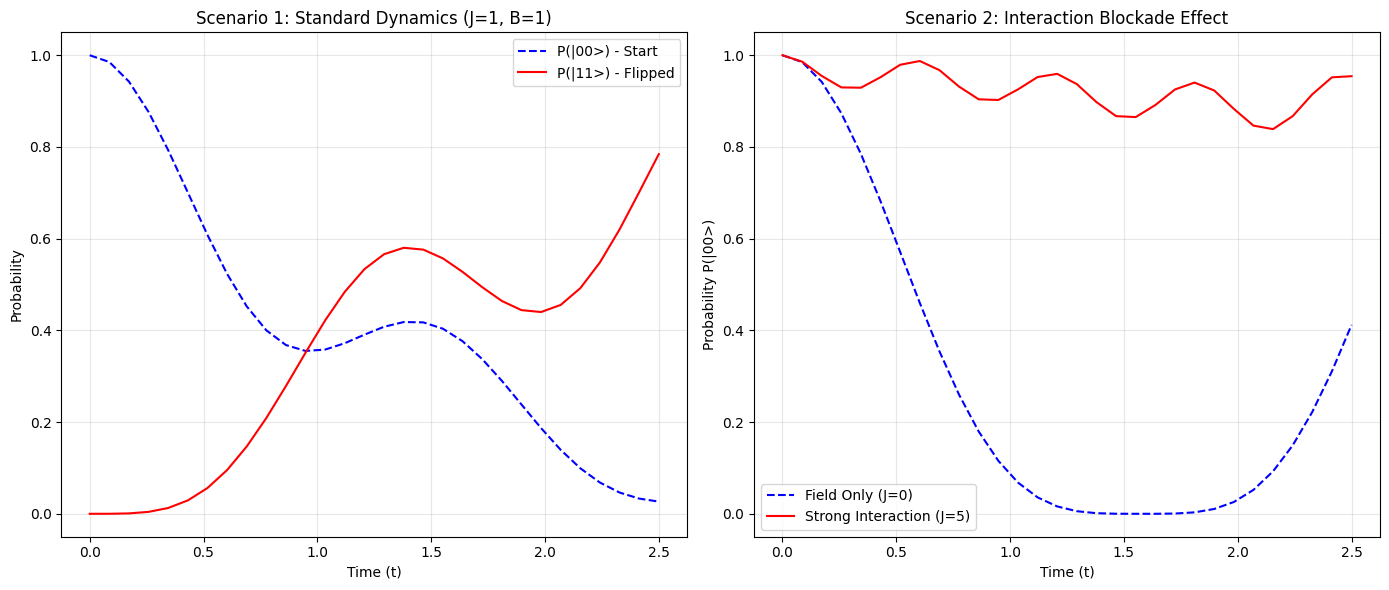

In [3]:
# Generalized Unified Trotter Simulation (Ising Model)

# This code defines a single, general-purpose simulation engine.
# Case 1 (Time Evolution): We set $J=1, B=1$ and watch how states $|00\rangle$ and $|11\rangle$ evolve.
# Case 2 (Regime Change): We vary $J$ and $B$ to see "Rabi Oscillations" vs. "Interaction Blockade".


# --- 1. The General Physical Engine ---
def generate_trotter_step(qubits, dt, J, B):
    n = len(qubits)
    if J != 0:
        for i in range(n - 1):
            yield cirq.CNOT(qubits[i], qubits[i+1])
            yield cirq.rz(rads=2 * J * dt).on(qubits[i+1])
            yield cirq.CNOT(qubits[i], qubits[i+1])
    if B != 0:
        for i in range(n):
            yield cirq.rx(rads=2 * B * dt).on(qubits[i])

def get_probabilities_over_time(J, B, t_max=2.5, steps=30):
    qubits = cirq.LineQubit.range(2)
    time_points = np.linspace(0, t_max, steps)
    probs_00 = []
    probs_11 = []

    for t in time_points:
        circuit = cirq.Circuit()

        if t > 0:
            dt = t / 10
            for _ in range(10):
                circuit.append(generate_trotter_step(qubits, dt, J, B))

        simulator = cirq.Simulator()

        # We explicitly tell Cirq: "Simulate these 2 qubits, even if the circuit is empty."
        result = simulator.simulate(circuit, qubit_order=qubits)
        # -----------------------

        probs_00.append(np.abs(result.final_state_vector[0])**2)
        probs_11.append(np.abs(result.final_state_vector[3])**2)

    return time_points, probs_00, probs_11

# --- 2. Plotting ---
plt.figure(figsize=(14, 6))

# Scenario 1: Standard Dynamics
plt.subplot(1, 2, 1)
times, p00, p11 = get_probabilities_over_time(J=1.0, B=1.0)
plt.plot(times, p00, label='P(|00>) - Start', color='blue', linestyle='--')
plt.plot(times, p11, label='P(|11>) - Flipped', color='red')
plt.title("Scenario 1: Standard Dynamics (J=1, B=1)")
plt.xlabel("Time (t)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, alpha=0.3)

# Scenario 2: Interaction Blockade
plt.subplot(1, 2, 2)
t_a, p00_a, _ = get_probabilities_over_time(J=0.0, B=1.0)
plt.plot(t_a, p00_a, label='Field Only (J=0)', color='blue', linestyle='--')

t_b, p00_b, _ = get_probabilities_over_time(J=5.0, B=1.0)
plt.plot(t_b, p00_b, label='Strong Interaction (J=5)', color='red')

plt.title("Scenario 2: Interaction Blockade Effect")
plt.xlabel("Time (t)")
plt.ylabel("Probability P(|00>)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()